# Pseudobulk Enrichment Analysis

When cell identity clusters are well-defined, it can be advantageous to perform
analyses at the pseudobulk level rather than at the single-cell level.
Pseudobulking involves aggregating counts across cells of the same type within
each sample, effectively creating sample-level gene expression profiles per cell
type. This approach helps mitigate the effects of technical noise and dropouts
common in single-cell data, enabling the detection of lowly expressed genes that
might otherwise be missed.

Moreover, conducting differential expression analysis (DEA) at the pseudobulk
level, treating each biological sample as the unit of observation, is
statistically more robust.
Unlike single-cell DEA, which assumes cells are independent (an assumption
that is violated when cells originate from the same individual), sample-level
pseudobulk analysis avoids inflation of p-values by reducing the number of
observations and by correctly modeling biological replication {cite:p}`psbulk`.

The resulting gene-level statistics from pseudobulk DEA can then be used as
input for downstream enrichment analyses.

In this notebook, we demonstrate how to use `decoupler` to infer transcription factor
(TF) and pathway enrichment scores from a multi-sample scRNA-seq human dataset.

The dataset includes 5k peripheral blood mononuclear cells (PBMCs) from healthy and
COVID-19 infected patients {cite:p}`covid5k`. It publicly available at the Single Cell
Expression Atlas ([E-MTAB-9221](https://www.ebi.ac.uk/gxa/sc/experiments/E-MTAB-9221/)).

## Loading Packages

In [1]:
import numpy as np
import scanpy as sc
import decoupler as dc

sc.set_figure_params(figsize=(3, 3), frameon=False)

## Loading The Dataset

In [2]:
adata = dc.ds.covid5k()
adata

AnnData object with n_obs × n_vars = 4903 × 14119
    obs: 'individual', 'sex', 'disease', 'celltype'
    obsm: 'X_umap'

The obtained {class}`anndata.AnnData` consist of raw integer transcript counts for ~5k cells
with measurements for ~15k genes.

The cell metadata stored in {attr}`anndata.AnnData.obs` can be inspected.

In [3]:
adata.obs

,individual,sex,disease,celltype
SAMEA6979322-AGGGTTTAGGGCGAAG,SARS-CoV2 pos Severe #3,not available,COVID-19,B cell
SAMEA6979322-CCGTTCAGTTGCTCGG,SARS-CoV2 pos Severe #3,not available,COVID-19,B cell
SAMEA6979322-AACGGGAGTCCTGAAT,SARS-CoV2 pos Severe #3,not available,COVID-19,T cell
SAMEA6979322-AGGAATATCACGGTCG,SARS-CoV2 pos Severe #3,not available,COVID-19,T cell
SAMEA6979322-AGACAAACAACAGCTT,SARS-CoV2 pos Severe #3,not available,COVID-19,T cell
...,...,...,...,...
SAMEA6979315-CACCGTTGTTACTCAG,Control #3,female,normal,T cell
SAMEA6979315-CATCCACGTCTGTCAA,Control #3,female,normal,T cell
SAMEA6979315-CATGCAAAGAAATTGC,Control #3,female,normal,T cell
SAMEA6979315-ACCTGTCTCGAAGCCC,Control #3,female,normal,T cell


And visualized.

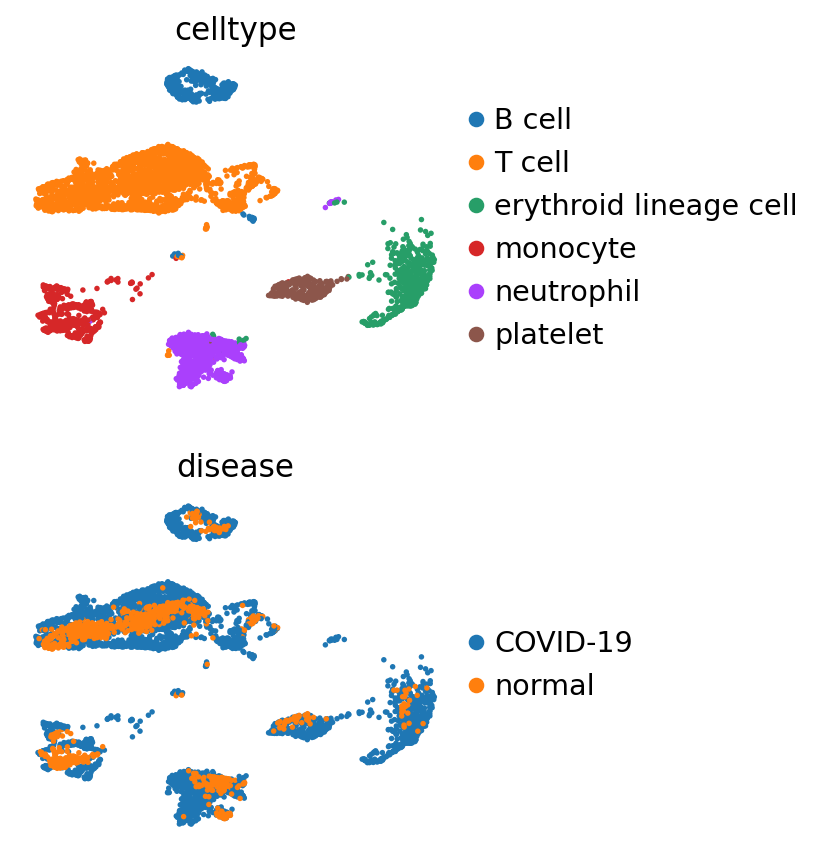

In [4]:
sc.pl.umap(adata, color=["celltype", "disease"], ncols=1)

## Pseudobulking

The pseudo-bulk approach involves the following steps:
1. Subsetting the cell type of interest
2. Extracting their raw integer counts
3. Summing their counts per gene into a single profile if they pass quality control

Then, DEA can be performed if there are at least two biological replicates per condition (more replicates are recommended).

Pseudobulking can easily be performed using the function {func}`decoupler.pp.pseudobulk`.
In this example, the counts are just summed, though other modes such as the mean or 
any custom aggregation function are available.
For more information, refer to the `mode` argument.

In [5]:
pdata = dc.pp.pseudobulk(
    adata=adata,
    sample_col="individual",
    groups_col="celltype",
    mode="sum",
)

A profile has been generated for each sample and cell type.
Quality control metrics can be then visualized.

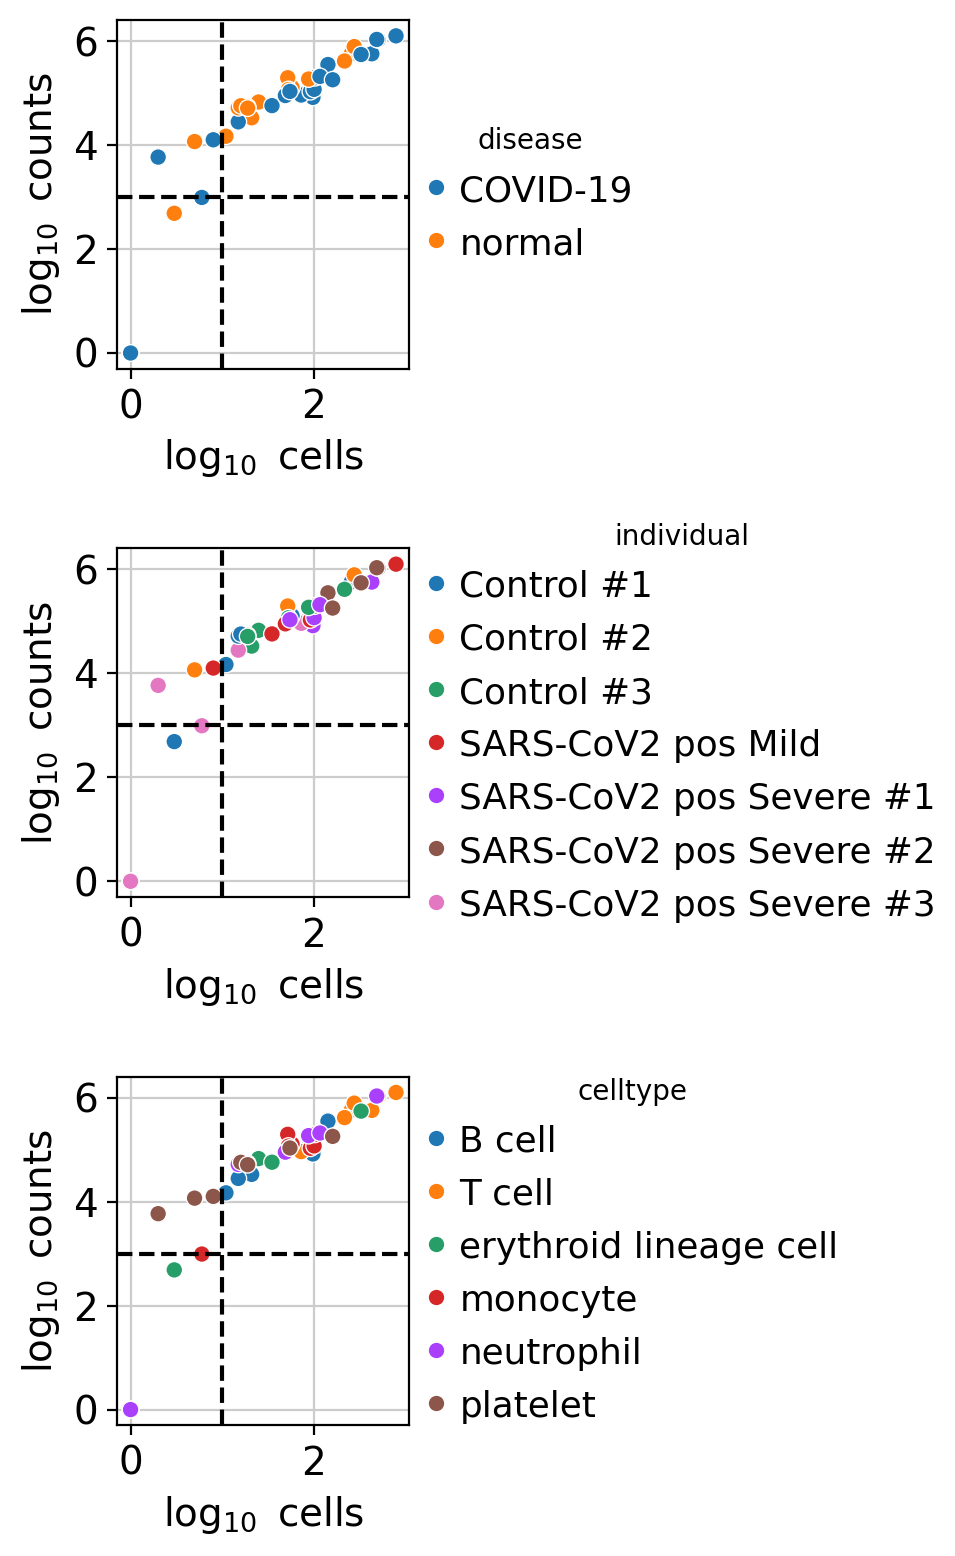

In [6]:
dc.pl.filter_samples(
    adata=pdata,
    groupby=["disease", "individual", "celltype"],
    min_cells=10,
    min_counts=1000,
    figsize=(5, 8),
)

Low-quality samples can be filtered based on two criteria: the number
of cells (`adata.obs.psbulk_cells`) and the total count sum (`adata.obs.psbulk_counts`).

In this dataset, the plots show that some generated profiles contain
fewer than 10 cells and 1000 counts.

These can be excluded using the function {func}`decoupler.pp.filter_samples`.

Thresholds are always dataset-dependent and arbitrary, but a common guideline
is to retain samples with at least 10 cells and 1000 total counts.

In [7]:
dc.pp.filter_samples(pdata, min_cells=10, min_counts=1000)

After removing low-quality samples, the remaining profiles count can be visualized.

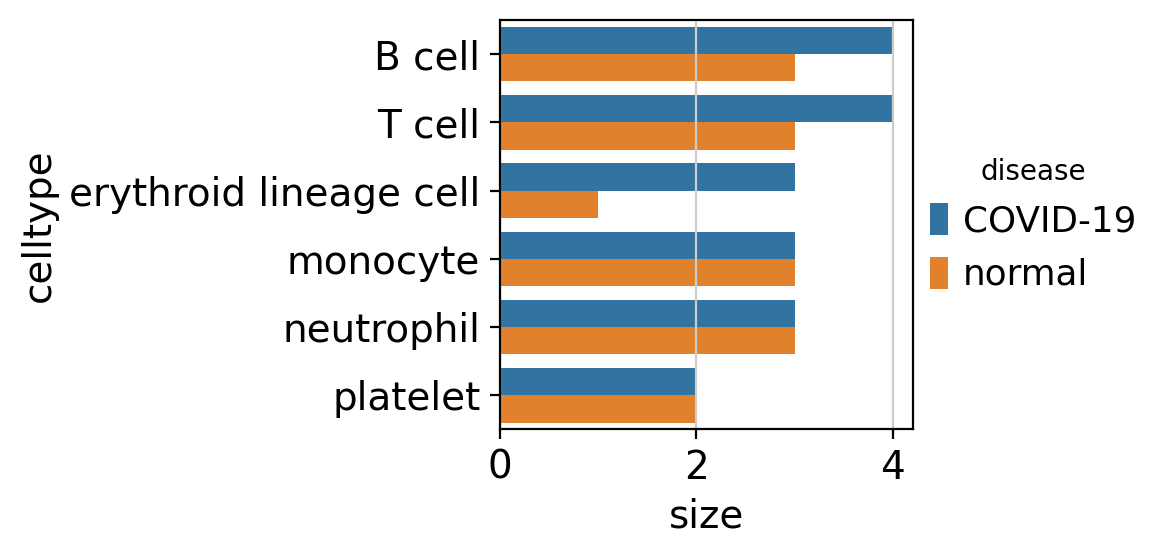

In [8]:
dc.pl.obsbar(adata=pdata, y="celltype", hue="disease", figsize=(6, 3))

### Variability Exploration
With pseudobulk profiles generated for each cell type and sample,
variability across them can now be explored.

This involves some basic preprocessing followed by principal component analysis (PCA).

In [9]:
# Store raw counts in layers
pdata.layers["counts"] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.pp.swap_layer(adata=pdata, key="counts", inplace=True)

After computing the PCs, associations or correlations between each inferred PC and the variables
in the metadata can be tested, depending on whether the variables are categorical or continuous.

This type of analysis is applicable to any dimensionality reduction method, such as factors
derived from non-negative matrix factorization.

In [10]:
dc.tl.rankby_obsm(pdata, key="X_pca")

The importance of each principal component (based on its explained variance ratio) and its associations
with metadata variables can then be visualized.

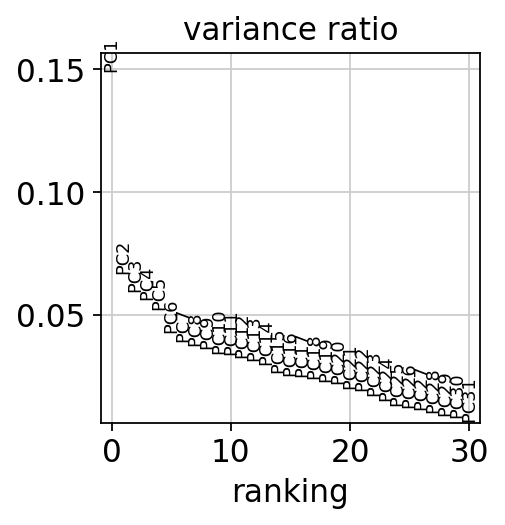

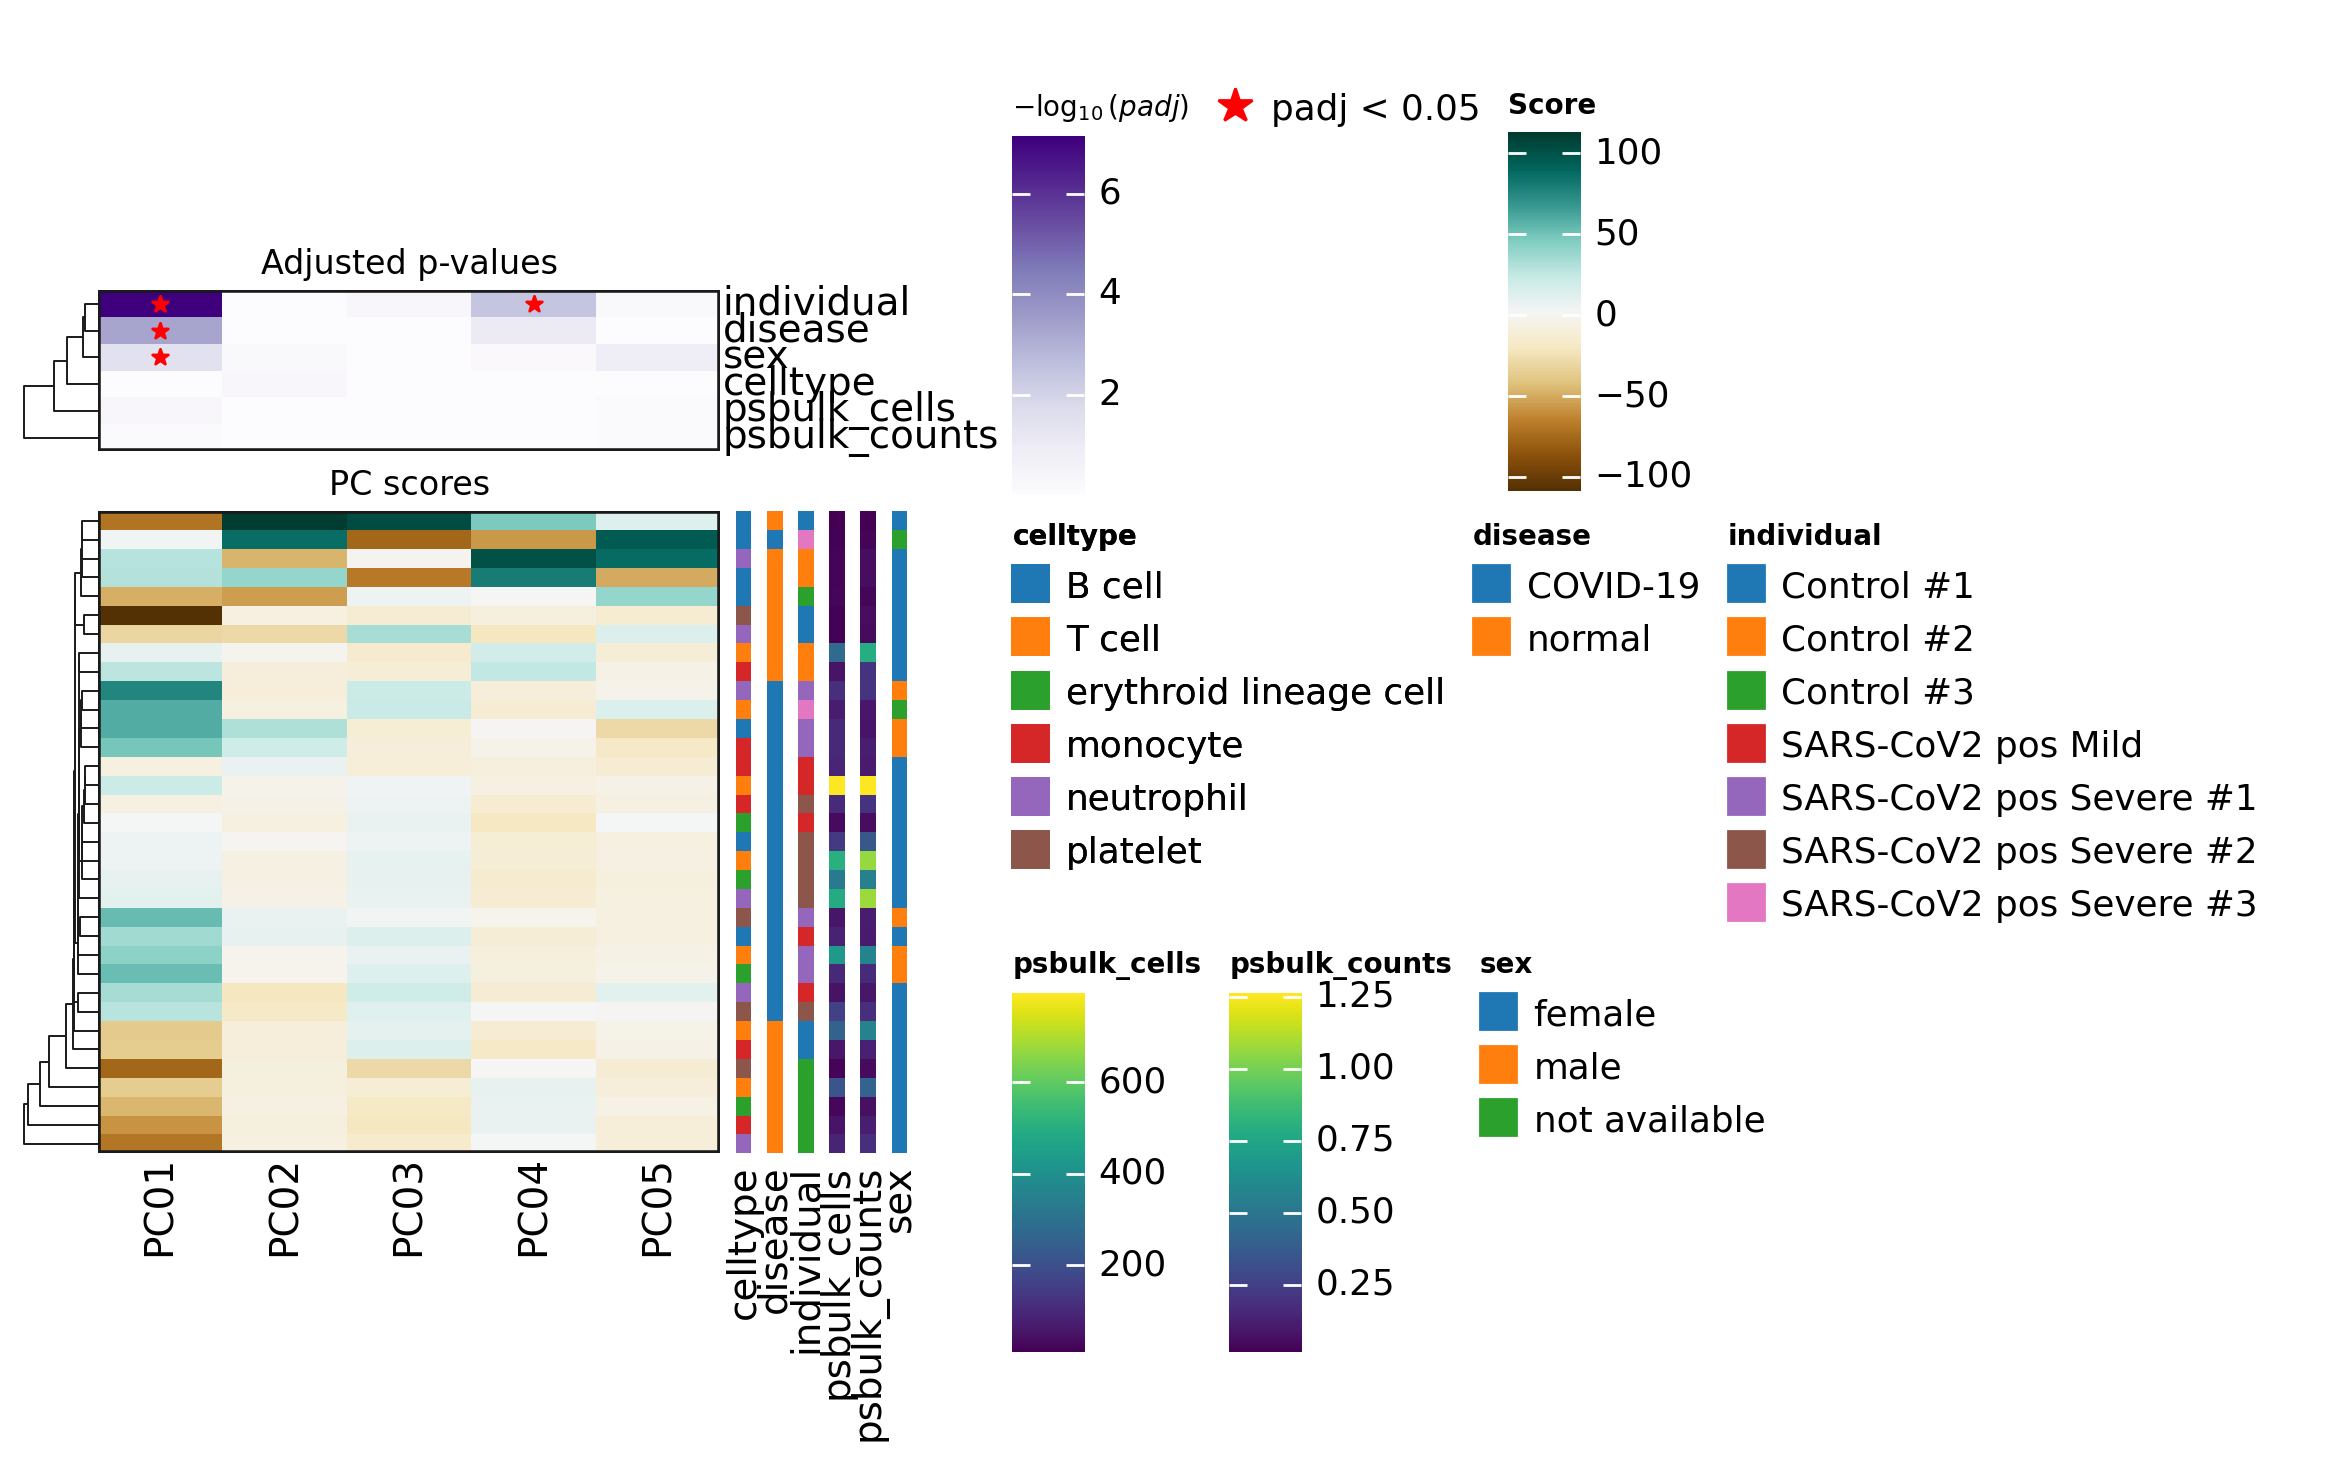

In [11]:
sc.pl.pca_variance_ratio(pdata)
dc.pl.obsm(adata=pdata, return_fig=True, nvar=5, titles=["PC scores", "Adjusted p-values"], figsize=(10, 5))

In this dataset, PC1 appears to explain the largest proportion of variance and is associated
with the metadata variables individual, disease, and cell type.

Metadata variables associated with PCs that capture a substantial amount of variance are
important and should be accounted for as relevant covariates in downstream differential
expression analysis when possible.

The principal components can also be directly visualized, colored by these metadata variables.

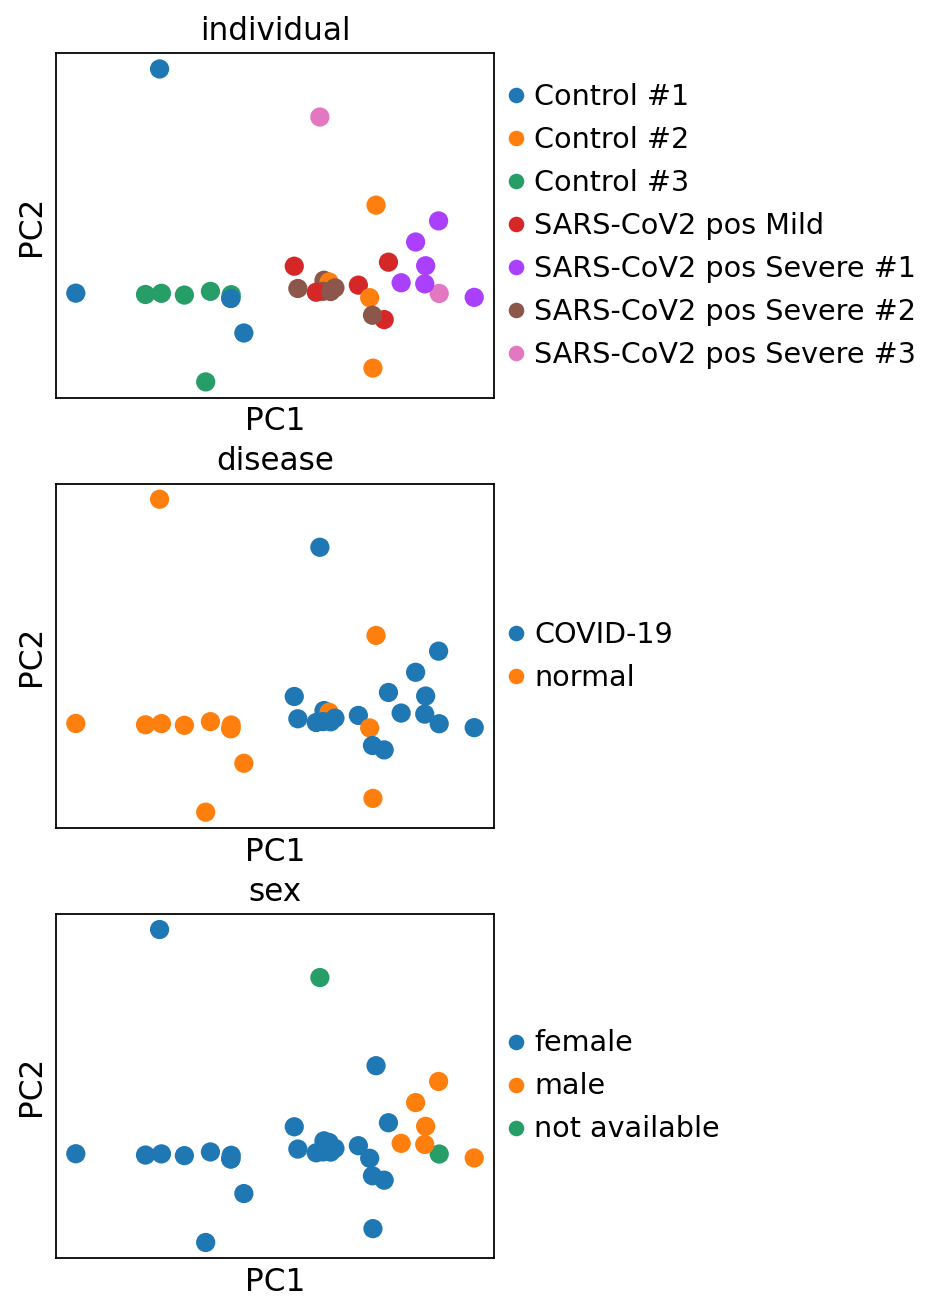

In [12]:
sc.pl.pca(
    pdata,
    color=["individual", "disease", "sex"],
    ncols=1,
    size=300,
    frameon=True,
)

A clear separation can be observed between control and infected patients.

### Feature selection

In addition to filtering low-quality samples, lowly or noisily expressed genes can also be filtered
prior to downstream analyses such as differential expression analysis. This step should be performed
at the cell type level, as different cell types may express distinct sets of genes.

In this vignette, we will focus on investigating the effects of COVID-19 on T cells but this should be done for every cell type of interest.

The first step
is to select the relevant samples.

In [13]:
tcells = pdata[pdata.obs["celltype"] == "T cell"].copy()
tcells

AnnData object with n_obs × n_vars = 7 × 14119
    obs: 'individual', 'celltype', 'sex', 'disease', 'psbulk_cells', 'psbulk_counts'
    var: 'mean', 'std'
    uns: 'log1p', 'pca', 'rank_obsm', 'individual_colors', 'disease_colors', 'sex_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts', 'X'

Two strategies are used to filter genes:

1) `decoupler.pp.filter_by_expr`: Retains genes with a minimum total number of reads across all samples (`min_total_count`)
   and a minimum number of counts in a given number of samples (`min_count`). This approach was introduced in
   [edgeR](https://rdrr.io/bioc/edgeR/man/filterByExpr.html){cite:p}`edger`.
2) `decoupler.pp.filter_by_prop`: Retains genes that are expressed in at least a specified proportion of cells (`min_prop`)
   across a minimum number of samples (`min_smpls`).

The number of retained genes can be visualized, and the filtering parameters can be adjusted interactively.

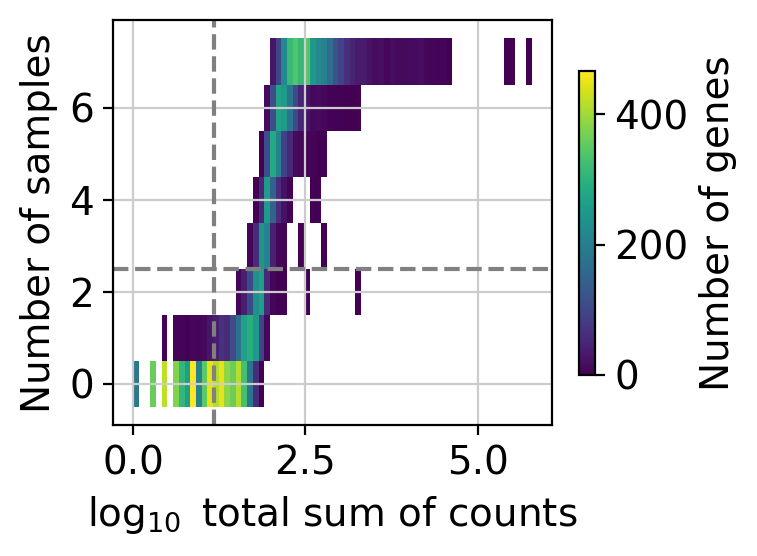

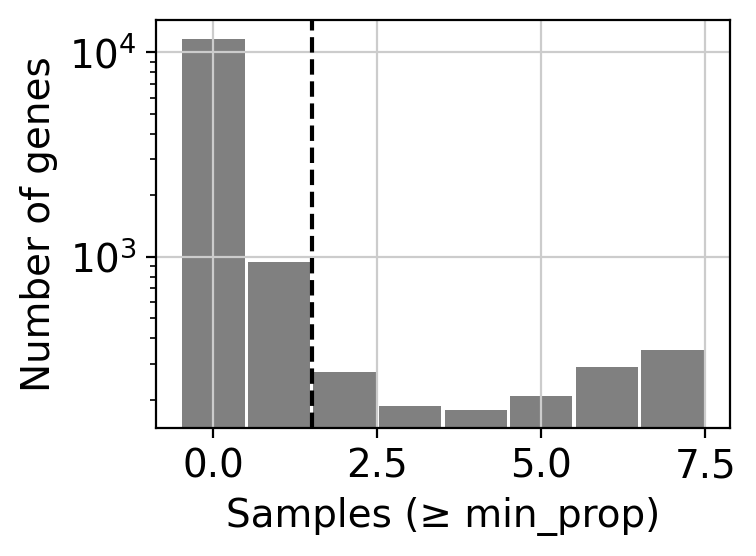

In [14]:
dc.pl.filter_by_expr(
    adata=tcells,
    group="disease",
    min_count=10,
    min_total_count=15,
    large_n=10,
    min_prop=0.7,
)
dc.pl.filter_by_prop(
    adata=tcells,
    min_prop=0.1,
    min_smpls=2,
)

The top plot displays gene frequencies based on the `filter_by_expr` metrics,
while the bottom plot corresponds to `filter_by_prop`.

Dashed lines indicate the current threshold values.
In the top plot, only genes in the upper-right quadrant are retained, in the
bottom plot, only those to the right of the vertical line are kept.

Although filtering thresholds are arbitrary, a common heuristic is to look
for bimodal distributions and set thresholds that separate low-quality
genes from the rest.

In this example, the default parameters retain a
substantial number of genes while removing potentially noisy ones.

Once the threshold parameters are set, the actual gene filtering can be performed by simply changing `pl` to `pp`.

In [15]:
dc.pp.filter_by_expr(
    adata=tcells,
    group="disease",
    min_count=10,
    min_total_count=15,
    large_n=10,
    min_prop=0.7,
)
dc.pp.filter_by_prop(
    adata=tcells,
    min_prop=0.1,
    min_smpls=2,
)
tcells

AnnData object with n_obs × n_vars = 7 × 1481
    obs: 'individual', 'celltype', 'sex', 'disease', 'psbulk_cells', 'psbulk_counts'
    var: 'mean', 'std'
    uns: 'log1p', 'pca', 'rank_obsm', 'individual_colors', 'disease_colors', 'sex_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts', 'X'

### Differential Expression Analysis

Differential expression analysis (DEA) can be used to identify genes that differ most between disease and control conditions.
Given the observed association of gene expression with both sex and disease status, the experimental design will include
these covariates to account for their effects.

We will use the Python implementation of the `DESeq2` framework {cite:p}`pydeseq`, though other tools like `limma`
{cite:p}`limma` or `edgeR` {cite:p}`edger` could also be used.
For a deeper understanding of how `pyDESeq2` works, refer to its
[official documentation](https://pydeseq2.readthedocs.io/en/latest/).

Note that even more complex experimental designs can be accommodated by adding additional factors to the `design_factors` argument.

In [16]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

# Build DESeq2 object
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=tcells,
    design_factors=["disease", "sex"],
    refit_cooks=True,
    inference=inference,
)

# Compute LFCs
dds.deseq2()

# Extract contrast between conditions
stat_res = DeseqStats(dds, contrast=["disease", "COVID-19", "normal"], inference=inference)

# Compute Wald test
stat_res.summary()

Using None as control genes, passed at DeseqDataSet initialization


/tmp/ipykernel_392303/981976294.py:7: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.22 seconds.

Fitting dispersion trend curve...
/home/nico/anaconda3/envs/funki/lib/python3.12/site-packages/pydeseq2/dds.py:805: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.02 seconds.

/home/nico/anaconda3/envs/funki/lib/python3.12/site-packages/pydeseq2/dds.py:542: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.22 seconds.

Fitting LFCs...
... done in 0.14 seconds.

Calcula

Log2 fold change & Wald test p-value: disease COVID-19 vs normal
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
PNRC1    223.074163        0.060597  0.539558  0.112309  0.910578  0.996278
CORO1B   101.927633       -0.518753  0.408971 -1.268435  0.204643  0.992450
RPL14    971.568552       -0.375462  0.394299 -0.952226  0.340983  0.992450
GPX4      91.602485       -0.183542  0.434627 -0.422297  0.672808  0.992450
ARL6IP4   79.199437       -0.099520  0.455668 -0.218405  0.827113  0.993331
...             ...             ...       ...       ...       ...       ...
SNX5      70.155574       -0.573185  0.479995 -1.194148  0.232420  0.992450
PPP1R3B   39.503494        0.266646  0.462568  0.576447  0.564313  0.992450
CHCHD2   167.927239       -0.496981  0.448425 -1.108283  0.267739  0.992450
ARPC5L    40.376432        0.316019  0.484717  0.651966  0.514423  0.992450
MOB1A     58.886480       -0.071471  0.438030 -0.163165  0.870389  0.994794

[1481 rows x 6 columns

... done in 0.16 seconds.



In [17]:
# Extract results
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
PNRC1,223.074163,0.060597,0.539558,0.112309,0.910578,0.996278
CORO1B,101.927633,-0.518753,0.408971,-1.268435,0.204643,0.992450
RPL14,971.568552,-0.375462,0.394299,-0.952226,0.340983,0.992450
GPX4,91.602485,-0.183542,0.434627,-0.422297,0.672808,0.992450
ARL6IP4,79.199437,-0.099520,0.455668,-0.218405,0.827113,0.993331
...,...,...,...,...,...,...
SNX5,70.155574,-0.573185,0.479995,-1.194148,0.232420,0.992450
PPP1R3B,39.503494,0.266646,0.462568,0.576447,0.564313,0.992450
CHCHD2,167.927239,-0.496981,0.448425,-1.108283,0.267739,0.992450
ARPC5L,40.376432,0.316019,0.484717,0.651966,0.514423,0.992450


The results can be visualized using a volcano plot.

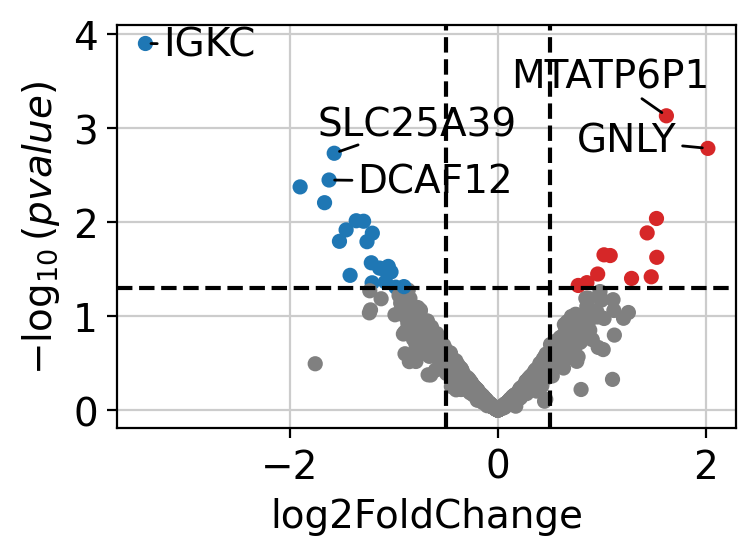

In [18]:
dc.pl.volcano(results_df, x="log2FoldChange", y="pvalue")

After performing DEA, we can use the resulting gene-level statistics for enrichment analysis.
While any statistic can be used, we recommend using `t-values` rather than `log2FCs`, as `t-values` account for the
significance of the change.
We will transform the obtained `t-values`, stored in the column `stat`, into a wide matrix format so that it can be
used with `decoupler`.

In [19]:
data = results_df[["stat"]].T.rename(index={"stat": "disease.vs.normal"})
data

,PNRC1,CORO1B,RPL14,GPX4,ARL6IP4,CCND3,KLRD1,ATP5F1B,KHDRBS1,LTB,...,TMEM50A,NAP1L1,CLIP1,EIF3H,PNN,SNX5,PPP1R3B,CHCHD2,ARPC5L,MOB1A
disease.vs.normal,0.112309,-1.268435,-0.952226,-0.422297,-0.218405,-1.290895,0.037555,-0.836684,-0.794858,-1.467891,...,-0.60501,-0.085722,-0.596025,-0.56962,0.514654,-1.194148,0.576447,-1.108283,0.651966,-0.163165


## Enrichment analysis

Enrichment analysis tests whether a specific set of omics features is "overrepresented" or "coordinated"
in the measured data compared to a background distribution. These sets are predefined based on existing
biological knowledge and may vary depending on the omics technology used.

Enrichment analysis requires the use of an enrichment method, and several options are available.
In the original manuscript of `decoupler` {cite:p}`decoupler`, we benchmarked multiple methods
and found that the univariate linear model (`ulm`) outperformed the others. Therefore, we will use
`ulm` in this vignette. 

The scores from {func}`decoupler.mt.ulm` should be interpreted such that larger magnitudes indicate
greater significance, while the sign reflects whether the features in the set are overrepresented
(positive) or underrepresented (negative) compared to the background.

### Transcription factor scoring from gene regulatory networks

Transcription factors (TFs) are genes that, once translated into proteins, bind to DNA and regulate
the expression of other genes by either promoting or inhibiting their transcription. Gene
Regulatory Networks (GRNs) capture these TF-gene interactions and can be constructed from prior
knowledge or inferred from omics data. The fundamental unit of a GRN is a TF and its associated target
genes, collectively known as a *regulon*. Each regulon functions as a gene set in enrichment analysis.

Although TFs are measured in transcriptomic data, their transcript levels often do not reflect their actual
activity in a given cell. Instead, scoring TFs through enrichment analysis based on the expression of
their target genes provides a more accurate representation of their regulatory activity
{cite:p}`grn_review`.

#### CollecTRI network
[CollecTRI](https://github.com/saezlab/CollecTRI) is a comprehensive resource containing a curated
collection of TFs and their transcriptional targets compiled from 12 different resources {cite:p}`collectri`. This collection
provides an increased coverage of transcription factors and a superior performance in identifying perturbed
TFs compared to other literature based GRNs such as 
[DoRothEA](https://saezlab.github.io/dorothea/) {cite:p}`dorothea`.
Similar to DoRothEA, interactions are weighted by their mode of regulation
(activation or inhibition).

In this tutorial we will use the human version but other organisms are available.
We can use `decoupler` to retrieve it from the [OmniPath](https://omnipathdb.org/) server {cite:p}`omnipath`.

<div class="alert alert-info">

**Note**
In this tutorial we use the network CollecTRI, but we could use any other GRN coming from an inference method such as [CellOracle](https://morris-lab.github.io/CellOracle.documentation/), [pySCENIC](https://pyscenic.readthedocs.io/en/latest/) or [SCENIC+](https://scenicplus.readthedocs.io/en/latest/). 
</div> 

In [20]:
collectri = dc.op.collectri(organism="human")
collectri

,source,target,weight,resources,references,sign_decision
0,MYC,TERT,1.0,DoRothEA-A;ExTRI;HTRI;NTNU.Curated;Pavlidis202...,10022128;10491298;10606235;10637317;10723141;1...,PMID
1,SPI1,BGLAP,1.0,ExTRI,10022617,default activation
2,SMAD3,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
3,SMAD4,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
4,STAT5A,IL2,1.0,ExTRI,10022878;11435608;17182565;17911616;22854263;2...,default activation
...,...,...,...,...,...,...
42985,NFKB,hsa-miR-143-3p,1.0,ExTRI,19472311,default activation
42986,AP1,hsa-miR-206,1.0,ExTRI;GEREDB;NTNU.Curated,19721712,PMID
42987,NFKB,hsa-miR-21,1.0,ExTRI,20813833;22387281,default activation
42988,NFKB,hsa-miR-224-5p,1.0,ExTRI,23474441;23988648,default activation


#### Scoring
TF scores can be easily computed by running the `ulm` method.

In [21]:
# Run
tf_acts, tf_padj = dc.mt.ulm(data=data, net=collectri)

# Filter by sign padj
msk = (tf_padj.T < 0.05).iloc[:, 0]
tf_acts = tf_acts.loc[:, msk]

tf_acts

,ATF2,ATF3,ATF4,GATA1,KLF8,MYC,NFE2
disease.vs.normal,3.691249,4.193026,3.18849,-3.935178,3.806934,-3.479875,-3.438817


The obtained scores for the most active and inactive TFs can be visualized as follows.

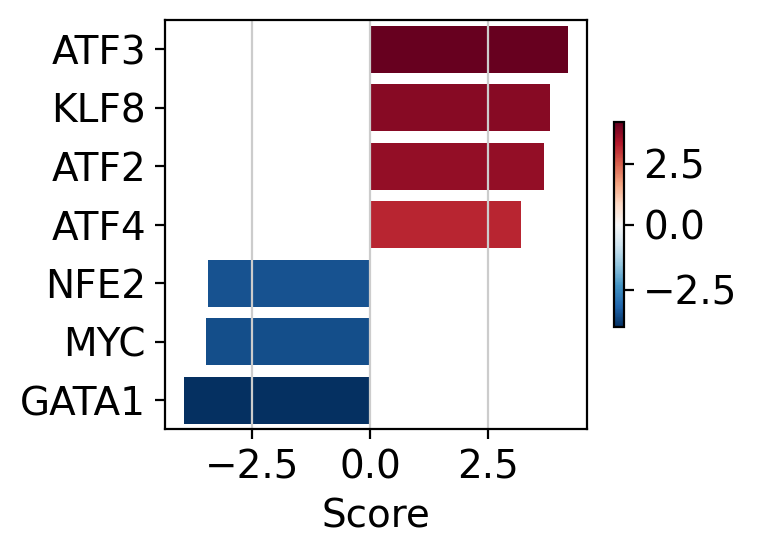

In [22]:
dc.pl.barplot(data=tf_acts, name="disease.vs.normal", figsize=(4, 3))

ATF3, KLF8 and ATF2 appear to be the most activated TFs in this treatment,
while GATA1, MYC and NFE2 appear to be inactivated.

A network of selected TFs (top and bottom ranked by activity) can also be visualized, with nodes colored by TF activity and
target gene expression.

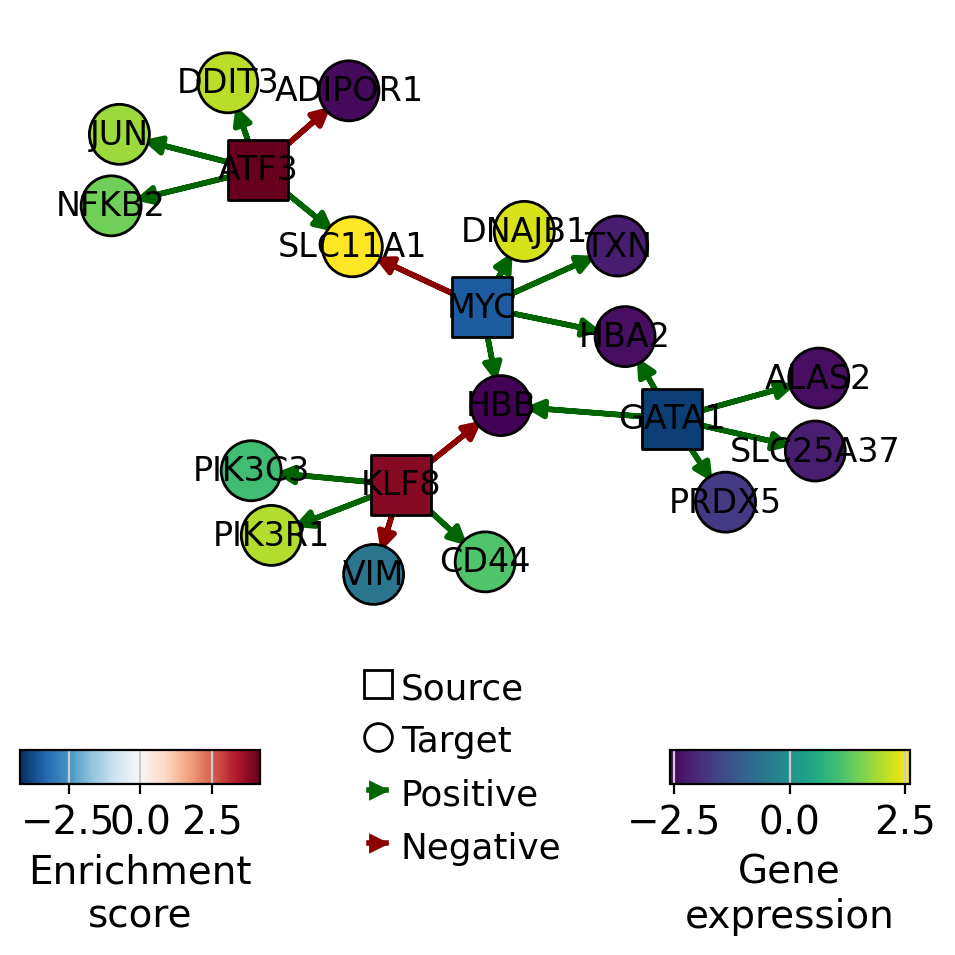

In [23]:
dc.pl.network(
    net=collectri,
    data=data,
    score=tf_acts,
    sources=["ATF3", "KLF8", "GATA1", "MYC"],
    targets=5,
    figsize=(5, 5),
    vcenter=True,
    by_abs=True,
    size_node=15,
)

ATF3 appears to be active in disease cells, as its positively regulated targets are upregulated.

If needed, we can also look at a volcano plot of the target genes.

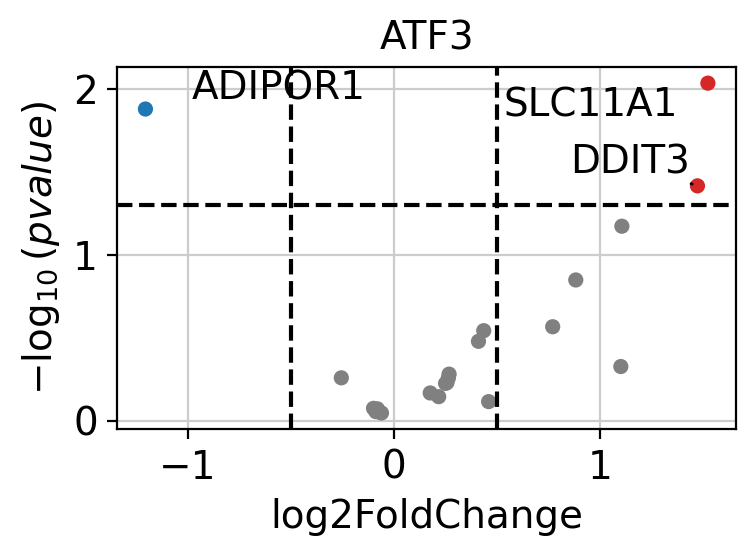

In [24]:
dc.pl.volcano(
    data=results_df,
    x="log2FoldChange",
    y="pvalue",
    net=collectri,
    name="ATF3",
    top=10,
)

### Pathway Scoring

The same approach used for TF scoring can also be applied to pathways. Numerous
databases provide curated pathway gene sets, with one of the most well-known being MSigDB, which
includes several collections {cite:p}`msigdb`. 
These and many other resources can be accessed using the function {func}`decoupler.op.resource`.
To view the list of available databases, use {func}`decoupler.op.show_resources`.

#### PROGENy Pathway Genes
[PROGENy](https://saezlab.github.io/progeny/) is a comprehensive resource that provides a curated
collection of pathways and their target genes, along with weights for each interaction
{cite:p}`progeny`.

Below is a brief description of each pathway:

- **Androgen**: involved in the growth and development of the male reproductive organs
- **EGFR**: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- **Estrogen**: promotes the growth and development of the female reproductive organs
- **Hypoxia**: promotes angiogenesis and metabolic reprogramming when O2 levels are low
- **JAK-STAT**: involved in immunity, cell division, cell death, and tumor formation
- **MAPK**: integrates external signals and promotes cell growth and proliferation
- **NFkB**: regulates immune response, cytokine production and cell survival
- **p53**: regulates cell cycle, apoptosis, DNA repair and tumor suppression
- **PI3K**: promotes growth and proliferation
- **TGFb**: involved in development, homeostasis, and repair of most tissues
- **TNFa**: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection
- **Trail**: induces apoptosis
- **VEGF**: mediates angiogenesis, vascular permeability, and cell migration
- **WNT**: regulates organ morphogenesis during development and tissue repair

This is how to access to it.

In [25]:
progeny = dc.op.progeny(organism="human")
progeny

,source,target,weight,padj
0,Androgen,TMPRSS2,11.490631,2.384806e-47
1,Androgen,NKX3-1,10.622551,2.205102e-44
2,Androgen,MBOAT2,10.472733,4.632376e-44
3,Androgen,KLK2,10.176186,1.944410e-40
4,Androgen,SARG,11.386852,2.790210e-40
...,...,...,...,...
62456,p53,ENPP2,2.771405,4.993215e-02
62457,p53,ARRDC4,3.494328,4.996747e-02
62458,p53,MYO1B,-1.148057,4.997905e-02
62459,p53,CTSC,-1.784693,4.998864e-02


#### Scoring
Pathway scores can be readily computed by running the `ulm` method.

In [26]:
# Run
pw_acts, pw_padj = dc.mt.ulm(data=data, net=progeny)

# Filter by sign padj
msk = (pw_padj.T < 0.05).iloc[:, 0]
pw_acts = pw_acts.loc[:, msk]

pw_acts

,Estrogen,Hypoxia,NFkB,PI3K,TGFb,TNFa
disease.vs.normal,-3.002012,3.774864,4.035946,-2.385132,3.201177,2.847875


The obtained scores for the most active and inactive pathways can be visualized as follows

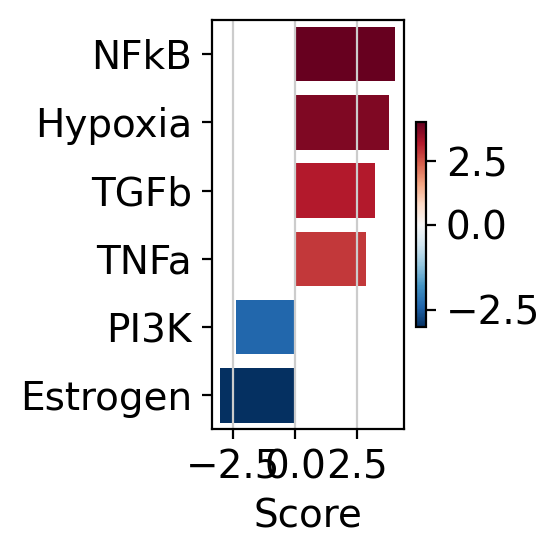

In [27]:
dc.pl.barplot(data=pw_acts, name="disease.vs.normal", figsize=(3, 3))

They can also be visualized as follows

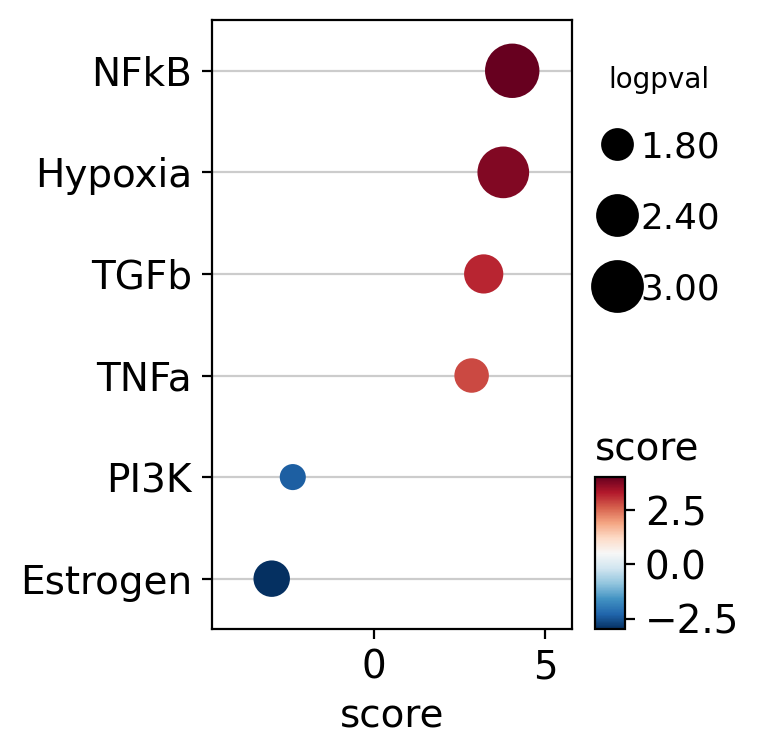

In [28]:
# Transform to df
df = pw_acts.melt(value_name="score").merge(
    pw_padj.melt(value_name="pvalue")
    .assign(logpval=lambda x: x["pvalue"].clip(2.22e-4, 1))
    .assign(logpval=lambda x: -np.log10(x["logpval"]))
)
dc.pl.dotplot(df=df, x="score", y="variable", s="logpval", c="score", scale=1, figsize=(4, 4))

COVID patients exhibit increased activity of the NFkB, Hypoxia, TGFb, and TNFa pathways in T cells.

Conversely, the disease is associated with reduced activity in pathways such as Estrogen and PI3K.

Targets of the NFkB pathway can be visualized in a scatter plot.

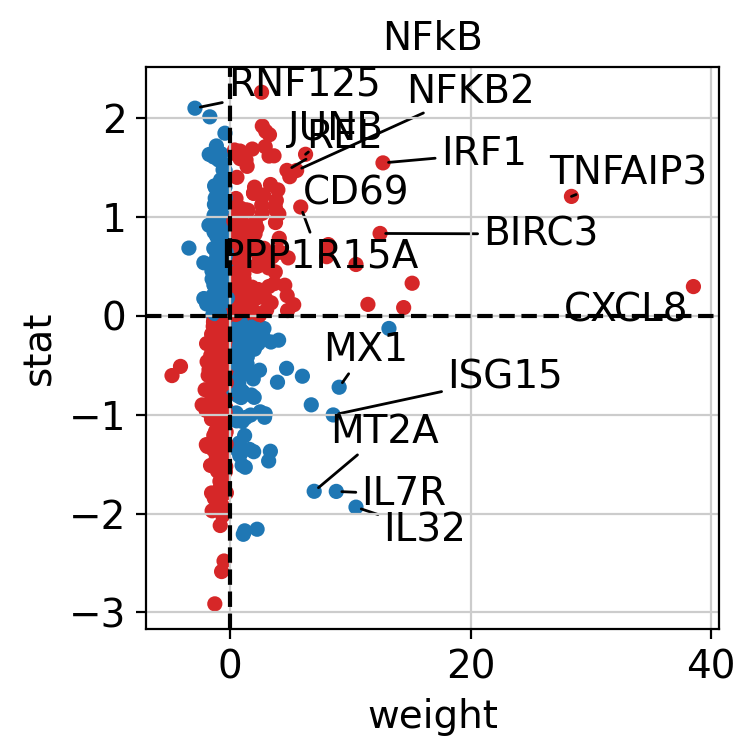

In [29]:
dc.pl.source_targets(data=results_df, x="weight", y="stat", net=progeny, name="NFkB", top=15, figsize=(4, 4))

The observed activation of the Hypoxia pathway is driven by the fact that many of its positively weighted
target genes have positive t-values.

We can also visualize the targets of NFkB as a leading edge plot.

Because PROGENy includes both positive and negative target genes,
the leading edge plot can be separated into positive and negative components.

(+) leading edge: ['NR4A2' 'PLK3' 'P2RX7' 'JUN' 'SQSTM1']
(-) leading edge: ['DCAF12' 'SNCA' 'ADIPOR1' 'ZMAT2' 'BSG']


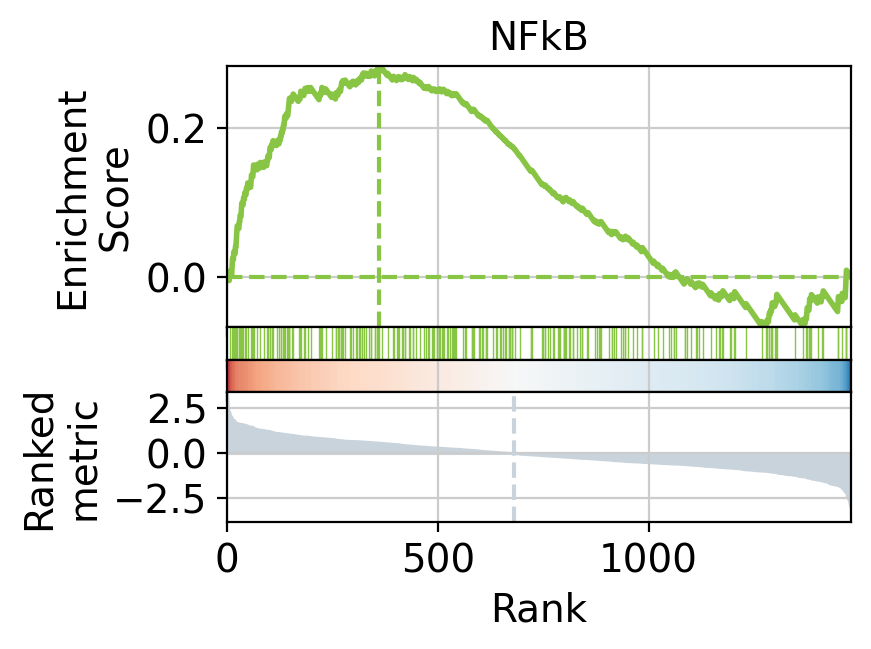

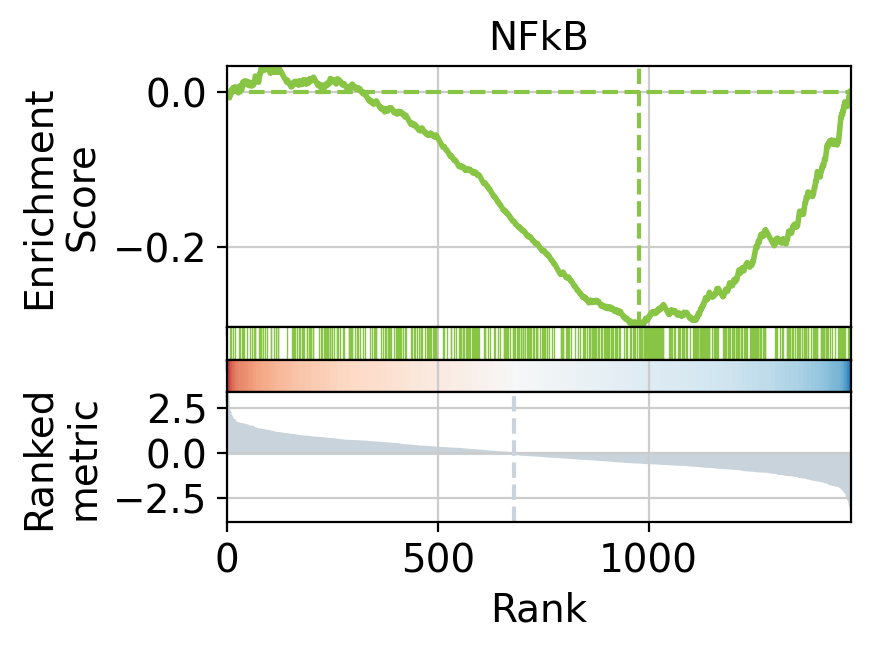

In [30]:
_, pos_le = dc.pl.leading_edge(
    results_df,
    stat="stat",
    net=progeny[progeny["weight"] > 0],
    name="NFkB",
)
print("(+) leading edge:", pos_le[:5])
_, neg_le = dc.pl.leading_edge(
    results_df,
    stat="stat",
    net=progeny[progeny["weight"] < 0],
    name="NFkB",
)
print("(-) leading edge:", neg_le[:5])

#### Hallmark gene sets
[Hallmark](https://www.gsea-msigdb.org/gsea/msigdb/human/collection_details.jsp#H)
gene sets are curated collections of genes that represent specific, well-defined biological states or processes.
They are part of MSigDB and were developed to reduce redundancy and improve interpretability compared to older,
more overlapping gene set collections {cite:p}`msigdb`.

A total of 50 gene sets are provided, designed to be non-redundant, concise, and biologically coherent.

This is how to access them.

In [31]:
hallmark = dc.op.hallmark(organism="human")
hallmark

,source,target
0,IL2_STAT5_SIGNALING,MAFF
1,COAGULATION,MAFF
2,HYPOXIA,MAFF
3,TNFA_SIGNALING_VIA_NFKB,MAFF
4,COMPLEMENT,MAFF
...,...,...
7313,PANCREAS_BETA_CELLS,STXBP1
7314,PANCREAS_BETA_CELLS,ELP4
7315,PANCREAS_BETA_CELLS,GCG
7316,PANCREAS_BETA_CELLS,PCSK2


#### Scoring
Pathway scores can be easily computed by running the `ulm` method.

In [32]:
# Run
hm_acts, hm_padj = dc.mt.ulm(data=data, net=hallmark)

# Filter by sign padj
msk = (hm_padj.T < 0.05).iloc[:, 0]
hm_acts = hm_acts.loc[:, msk]

hm_acts

,HEME_METABOLISM,INFLAMMATORY_RESPONSE,MYC_TARGETS_V1,OXIDATIVE_PHOSPHORYLATION,REACTIVE_OXYGEN_SPECIES_PATHWAY,TNFA_SIGNALING_VIA_NFKB
disease.vs.normal,-5.756127,2.888689,-6.114809,-5.695156,-2.994277,6.676313


The obtained scores for the most active and inactive pathways can be visualized as follows.

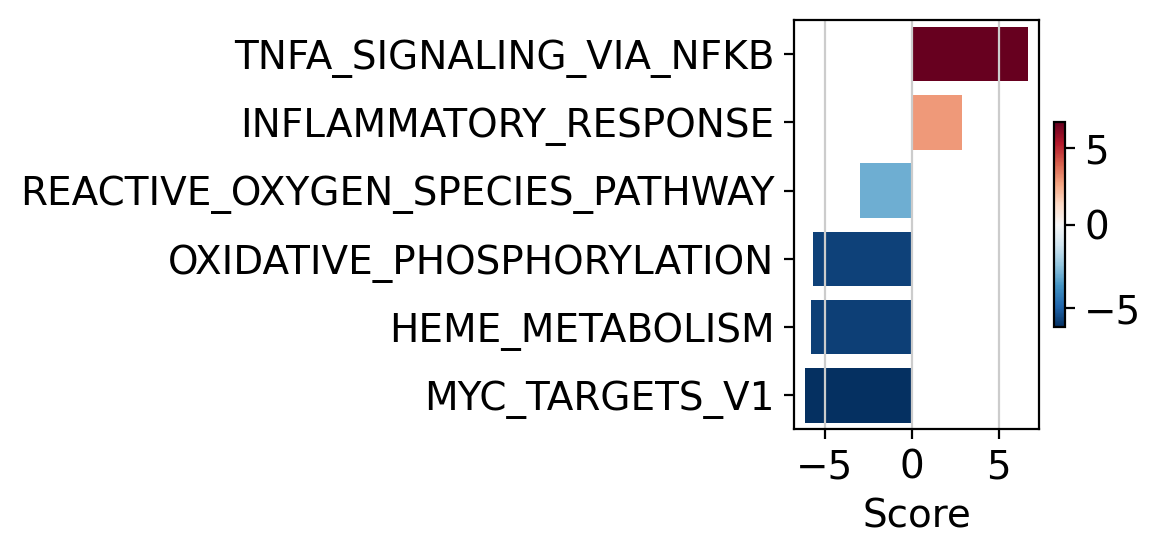

In [33]:
dc.pl.barplot(data=hm_acts, name="disease.vs.normal", figsize=(6, 3))

Or alternatively like this.

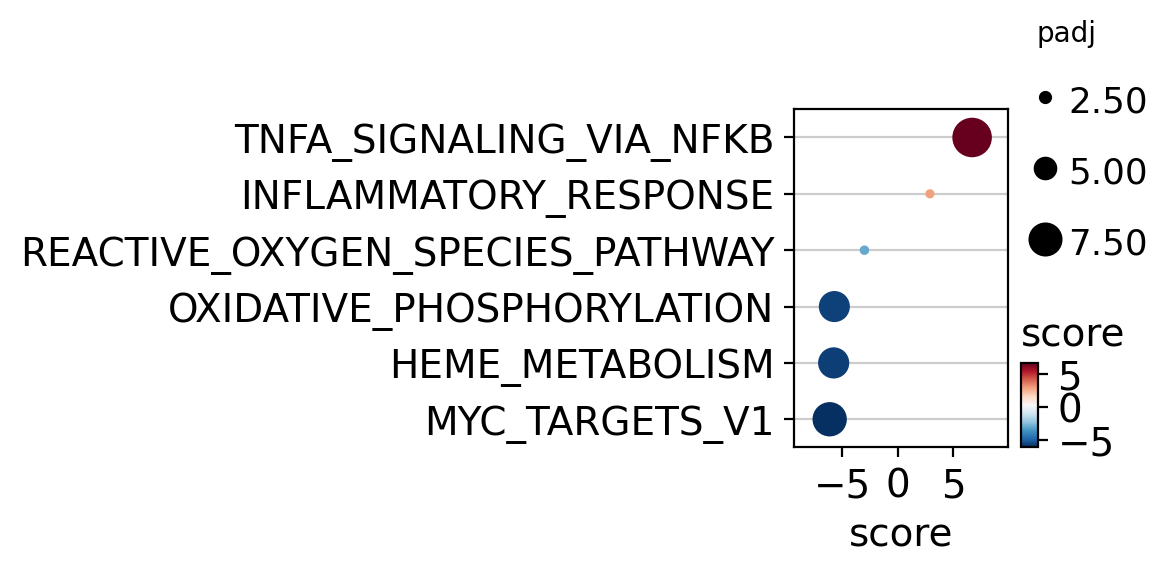

In [34]:
# Tranform to df
df = hm_acts.melt(value_name="score").merge(
    hm_padj.melt(value_name="pvalue")
    .assign(padj=lambda x: x["pvalue"].clip(2.22e-16, 1))
    .assign(padj=lambda x: np.log10(x["pvalue"]))
)
dc.pl.dotplot(df=df, x="score", y="variable", s="padj", c="score", scale=0.25, figsize=(6, 3))

COVID patients exhibit increased activity for `TNFA_SIGNALING_VIA_NFKB`.

Conversely, the disease is associated with reduced activity in 
`MYC_TARGETS_V1`, `HEME_METABOLISM` and `OXIDATIVE_PHOSPHORYLATION`.

Targets of the `TNFA_SIGNALING_VIA_NFKB` can be visualized as a leading
edge plot.

leading edge: ['NR4A2' 'JUN' 'SQSTM1' 'JUNB' 'IER5']


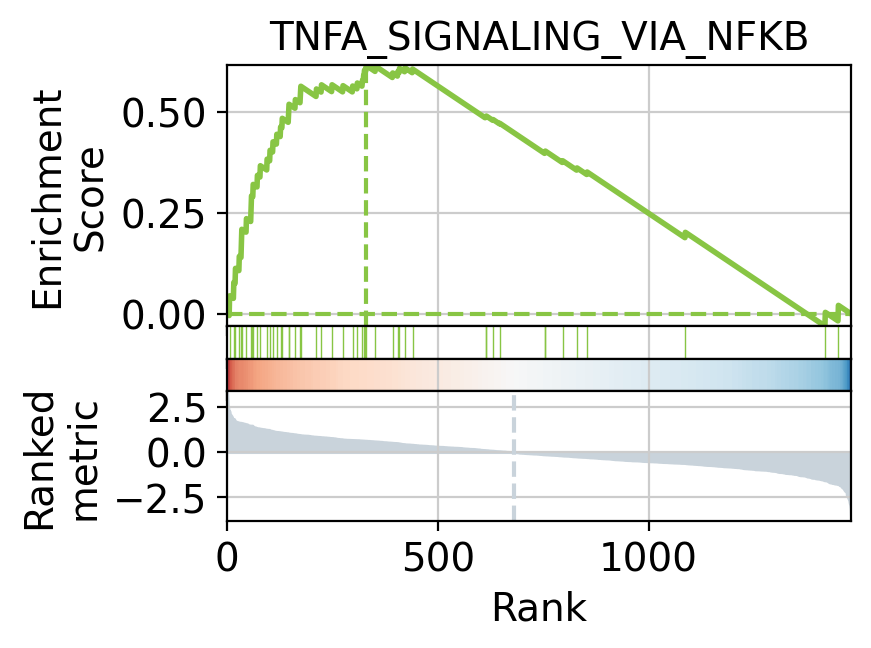

In [35]:
_, le = dc.pl.leading_edge(
    results_df,
    stat="stat",
    net=hallmark,
    name="TNFA_SIGNALING_VIA_NFKB",
)
print("leading edge:", le[:5])